In [1]:
USE_CUDA = True

In [2]:
from utils import *
from models import *

In [3]:
captions_train_normalized = [[normalize(caption) for caption in captions] for captions in captions_train]

In [4]:
def show_length_count(captions_list):
    length_count = list()
    for captions in captions_list:
        if len(captions) == 0:
            print('NO CAPTION!!')
        for caption in captions:
            L = len(caption.split(' '))
            length_count.append(L)

    print(min(length_count), max(length_count), len(length_count))

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.hist(length_count, max(length_count) - min(length_count) + 1)
    plt.show()

1 46 24232


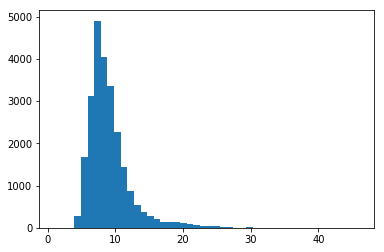

In [5]:
show_length_count(captions_train_normalized)

In [6]:
def filter_captions(captions_list):
    filtered_captions_list = []
    for captions in captions_list:
        filtered_captions = []
        for caption in captions:
            L = len(caption.split(' '))
            if MIN_LENGTH <= L <= MAX_LENGTH:
                filtered_captions.append(caption)
        filtered_captions_list.append(filtered_captions)
    return filtered_captions_list

5 20 23585


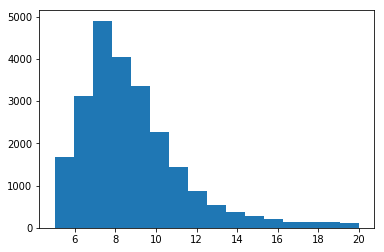

In [7]:
captions_train_filtered = filter_captions(captions_train_normalized)

show_length_count(captions_train_filtered)

In [8]:
output_lang = Lang()

print("Indexing words...")
for captions in captions_train_filtered:
    for caption in captions:
        output_lang.index_words(caption)

print('Indexed {} words in output'.format(output_lang.n_words))

Indexing words...
Indexed 5709 words in output


In [9]:
MIN_COUNT = 2

output_lang.trim(MIN_COUNT)

keep_words 3538 / 5706 = 0.6200


In [10]:
captions_train_trimmed = []

for captions in captions_train_filtered:
    keep_captions = []
    for caption in captions:
        keep = True

        for word in caption.split(' '):
            if word not in output_lang.word2index:
                keep = False
                break

        # Remove if pair doesn't match input and output conditions
        if keep:
            keep_captions.append(caption)
    
    captions_train_trimmed.append(keep_captions)

L1 = sum([len(captions) for captions in captions_train_trimmed])
L2 = sum([len(captions) for captions in captions_train_filtered])
print("Trimmed from %d pairs to %d, %.4f of total" % (L2, L1, L1 / L2))

Trimmed from 23585 pairs to 21672, 0.9189 of total


In [49]:
teacher_forcing_ratio = 0.5
clip = 5.0
num_beams = 3

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word
    losses = [0]

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_context, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        beams = [[(decoder_input, decoder_context, decoder_hidden)]]
        num_finished = 0
        
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            beams_new = []
            losses_new = []
            for i, beam in enumerate(beams):
                decoder_input, decoder_context, decoder_hidden = beam[-1]
                if decoder_input.data[0][0] == EOS_token:
                    continue
                
                decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_context, decoder_hidden, encoder_outputs
                )
            
                losses[i] += criterion(decoder_output, target_variable[di])
            
                # Get most likely word index (highest value) from output
                topv, topi = decoder_output.data.topk(num_beams)
                for j in range(num_beams):
                    ni = topi[0][j]
                    decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
                    if USE_CUDA: decoder_input = decoder_input.cuda()
                    
                    beams_new.append(beam + [(decoder_input, decoder_context, decoder_hidden)])
                    losses_new.append(losses[i])

                    # Stop at end of sentence (not necessary when using known targets)
                    if ni == EOS_token:
                        num_finished += 1

            if len(losses_new) > num_beams:
                
                        
            beams = beams_new
            losses = losses_new
            
            if num_finished >= num_beams:
                break
    
#         print(losses)
        loss = min([i[0] for i in losses])
    
    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [12]:
def evaluate_on_train(index, encoder, decoder, max_length=80):
    input_variable = X_train[index]
    input_variable = Variable(torch.FloatTensor(input_variable))
    if USE_CUDA: input_variable = input_variable.cuda()
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_context, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [13]:
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [26]:
attn_model = 'general'
hidden_size = 256
n_layers = 1
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(num_features, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [37]:
# Configuring training
# n_epochs = 100000
# plot_every = 200
# print_every = 100
# save_every = 1000

n_epochs = 10
plot_every = 2
print_every = 1
save_every = 10


# Keep track of time elapsed and running averages
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [50]:
# Begin!
import time
import random

start = time.time()

for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    index = random.randrange(num_videos)
    input_variable = X_train[index]
    input_variable = Variable(torch.FloatTensor(input_variable))
    if USE_CUDA: input_variable = input_variable.cuda()
    
    captions = captions_train_trimmed[index]
    num_captions = len(captions)
    caption = captions[epoch % num_captions]
    target_variable = variable_from_sentence(output_lang, caption)
    
    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        with open('./log.txt', 'a') as log_f:
            log_f.write(print_summary + '\n')
        
        encoder.eval()
        decoder.eval()
        output_words, decoder_attn = evaluate_on_train(index, encoder, decoder)
        output_sentence = ' '.join(output_words[:-1])
        print('Truth:   ', captions[epoch % num_captions])
        print('Predict: ', output_sentence)
        encoder.train()
        decoder.train()
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % save_every == 0:
        MODEL_DIR = '../models/new/'
        torch.save(encoder.state_dict(), MODEL_DIR + './encoder_epoch{}.sd'.format(str(epoch)))
        torch.save(decoder.state_dict(), MODEL_DIR + './decoder_epoch{}.sd'.format(str(epoch)))
        

KeyboardInterrupt: 

In [17]:
def evaluate(id_, max_length=80):
    index = filenames_test.index(id_ + '.npy')
    input_variable = X_test[index]
    input_variable = Variable(torch.FloatTensor(input_variable))
    if USE_CUDA: input_variable = input_variable.cuda()
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_context, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [19]:
def postprocess(words):
    for i in range(len(words) - 1, -1, -1):
        if words[i] == '.':
            continue
        if words[i] == 'a' and words[i-1] == 'a':
            continue
        break
    
    return words[:i+1]

print(postprocess(['a', 'boy', 'is', 'a', 'a', '.', '.']))

['a', 'boy', 'is', 'a']


In [20]:
ids = [
    'klteYv1Uv9A_27_33.avi',
    '5YJaS2Eswg0_22_26.avi',
    'UbmZAe5u5FI_132_141.avi',
    'JntMAcTlOF0_50_70.avi',
    'tJHUH9tpqPg_113_118.avi',
]

for id_ in ids:
    encoder.eval()
    decoder.eval()
    
    output_words, decoder_attn = evaluate(id_)
    output_sentence = ' '.join(postprocess(output_words[:-1]))
    print(output_sentence)
    
    encoder.train()
    decoder.train()

a is is is . is . is . is
a is is . is . is . is
a is is is is . is is . is is . is is . is is . is is . is is . is is . is is
a is is . is . is . is
a is is . is . is


In [21]:
encoder.eval()
decoder.eval()

with open('output_3.csv', 'w') as f:
    for i in range(num_videos_test):
        id_ = filenames_test[i][:-4]
        output_words, decoder_attn = evaluate(id_)
        output_sentence = ' '.join(postprocess(output_words[:-1]))
        f.write(id_ + ',' + output_sentence + '\n')

encoder.train()
decoder.train()

KeyboardInterrupt: 

In [ ]:
encoder.eval()
decoder.eval()

torch.save(encoder, MODEL_DIR + './encoder_z2.sd')
torch.save(decoder, MODEL_DIR + './decoder_z2.sd')

encoder.train()
decoder.train()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)